## 4.3 Predicting house price: A regression example

### 4.3.1 The Boston housing price dataset

In this section, we’ll attempt to predict the median price of homes in a given Boston
suburb in the mid-1970s, given data points about the suburb at the time, such as the
crime rate, the local property tax rate, and so on


+ It has relatively few data points: only
506, split between 404 training samples and 102 test samples. 

+ And each feature in the
input data (for example, the crime rate) has a different scale. 

Listing 4.23 Loading the Boston Housing dataset

In [65]:
from tensorflow import keras
from keras.datasets import boston_housing
(train_data,train_targets),(test_data,test_targets) = boston_housing.load_data()

In [66]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [67]:
print(train_targets.shape)
print(train_targets[:10])


(404,)
[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


### 4.3.2 Preparing the data

It would be problematic to feed into a neural network values that all take wildly different ranges. The model might be able to automatically adapt to such heterogeneous
data, but it would definitely make learning more difficult.

Listing 4.24 Normalizing the data

In [68]:
import numpy as np
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std


### 4.3.3 Building the model

Because so few samples are available, we’ll use a very small model with two intermediate layers, each with 64 units. 

In general, the less training data you have, the worse
overfitting will be, and using a small model is one way to mitigate overfitting.

In [69]:
from keras import layers 
def build_model():

    model = keras.Sequential([
                            layers.Dense(64,activation='relu'),
                            layers.Dense(64,activation='relu'),
                            layers.Dense(1)
                        ])
    
    model.compile(optimizer=keras.optimizers.RMSprop(),
                loss = keras.losses.MeanSquaredError(),
                metrics = ['mae'])
    
    return model



The model ends with a single unit and no activation (it will be a linear layer). 

This is a typical setup for scalar regression (a regression where you’re trying to predict a single
continuous value). 

Applying an activation function would constrain the range the output can take

+ Note that we compile the model with the mse loss function—mean squared error(MSE), the
square of the difference between the predictions and the targets. This is a widely used
loss function for regression problems

+ We’re also monitoring a new metric during training: mean absolute error (MAE). It’s the absolute value of the difference between the predictions and the targets. For instance, an
MAE of 0.5 on this problem would mean your predictions are off by $500 on average.

### 4.3.4 Validating your approach using K-fold validation

Because we have so few data points, the validation set would end up being very small (for instance, about 100 examples). 

As a consequence, the validation scores might change a lot depending on which data
points we chose for validation and which we chose for training:

Might have a high variance with regard to the validation split. This would prevent us
from reliably evaluating our model

K-fold cross-validation consists of splitting the available data into K partitions (typically K = 4 or 5), instantiating K identical models, and training each one on K – 1 partitions while evaluating
on the remaining partition. The validation score for the model used is then the average of the K validation scores obtained. In terms of code, this is straightforward

In [70]:
k = 4 
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []

for i in range(k):
    print("Processing fold\t{}".format(i))
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    partial_train_data = np.concatenate(
                                        [train_data[:i*num_val_samples],
                                         train_data[(i+1)*num_val_samples:]  ]
                                         ,axis=0
                                        )
    partial_train_targets = np.concatenate(
                                        [train_targets[:i*num_val_samples],
                                         train_targets[(i+1)*num_val_samples:]  ]
                                         ,axis=0
                                        )
    model = build_model()
    model.fit( partial_train_data,partial_train_targets,epochs=num_epochs,batch_size=16,verbose=0  )
    ## The verbose here control the display of epochs, if set verbose = 0 ,there will be nothing to show on screen
    val_mse,val_mae = model.evaluate(val_data,val_targets,verbose=0)
    all_scores.append(val_mae) 

Processing fold	0
Processing fold	1
Processing fold	2
Processing fold	3


In [71]:
all_scores

[1.7854384183883667, 2.598708152770996, 2.556169033050537, 2.4664270877838135]

In [72]:
np.mean(all_scores)

2.3516856729984283

The different runs do indeed show rather different validation scores, from 2.1 to 3.1.
The average (2.6) is a much more reliable metric than any single score—that’s the
entire point of K-fold cross-validation. 

In this case, we’re off by $2,600 on average,
which is significant considering that the prices range from $10,000 to $50,000

Let’s try training the model a bit longer: 500 epochs. 

To keep a record of how well
the model does at each epoch, we’ll modify the training loop to save the per-epoch
validation score log for each fold.

In [73]:
k = 4 
num_val_samples = len(train_data)//k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print("Processing fold\t{}".format(i))
    val_data = train_data[i*num_val_samples:(i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(i+1)*num_val_samples]
    partial_train_data = np.concatenate(
                                        [train_data[:i*num_val_samples],
                                         train_data[(i+1)*num_val_samples:]  ]
                                         ,axis=0
                                        )
    partial_train_targets = np.concatenate(
                                        [train_targets[:i*num_val_samples],
                                         train_targets[(i+1)*num_val_samples:]  ]
                                         ,axis=0
                                        )
    model = build_model()
    history = model.fit( partial_train_data,partial_train_targets,epochs=num_epochs,batch_size=16,verbose=0  )
    ## The verbose here control the display of epochs, if set verbose = 0 ,there will be nothing to show on screen
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)

Processing fold	0
Processing fold	1
Processing fold	2
Processing fold	3


Listing 4.28 Building the history of successive mean K-fold validation scores

In [74]:
np.array(all_mae_histories).shape


(4, 500)

In [75]:
average_mae_history = [
                        np.mean(  [ x[i] for x in all_mae_histories] )for i in range(num_epochs)   ] 

print(np.array(average_mae_history).shape)

print(len(average_mae_history))

(500,)
500


The average_mae_history is calculate the 4 mae value of 4 times folds at each epochs 

Listing 4.29 Plotting validation scores

Text(0, 0.5, 'Validation MAE')

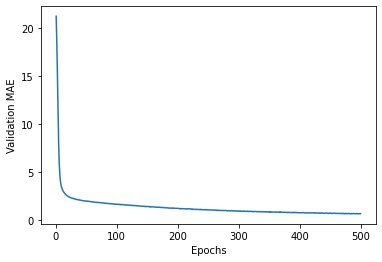

In [76]:
from matplotlib import pyplot as plt 

plt.plot(range(1,len(average_mae_history)+1),average_mae_history   )
plt.xlabel("Epochs")
plt.ylabel('Validation MAE')


Listing 4.30 Plotting validation scores, excluding first 10 data points

Text(0, 0.5, 'Validation MAE')

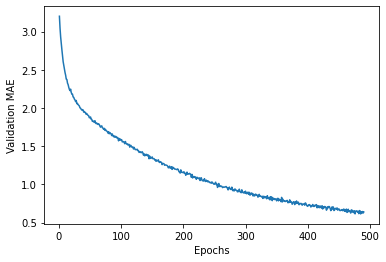

In [77]:
plt.clf()
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1,len(truncated_mae_history)+1),truncated_mae_history   )
plt.xlabel("Epochs")
plt.ylabel('Validation MAE')

As you can see in figure 4.10, validation MAE stops improving significantly after
120–140 epochs (this number includes the 10 epochs we omitted). Past that point,
we start overfitting.

Listing 4.31 Training the final model

In [78]:
model = build_model()
model.fit(train_data,train_targets,epochs=130,batch_size=16,verbose=0)

test_mse_score,test_mae_score = model.evaluate(test_data,test_targets)
 

4/4 [==============================] - 0s 1ms/step - loss: 15.4744 - mae: 2.6792


In [79]:
test_mae_score

2.679205894470215

### 4.3.5 Generating prediction on new data

When calling predict() on our binary classification model, we retrieved a scalar score
between 0 and 1 for each input sample. With our multiclass classification model, we
retrieved a probability distribution over all classes for each sample. Now, with this scalar regression model, predict() returns the model’s guess for the sample’s price in
thousands of dollars

In [80]:
predictions = model.predict(test_data)
predictions[0]

4/4 [==============================] - 0s 1ms/step


array([8.01618], dtype=float32)

### 4.3.6 Wrapping up

1. Regression is done using different loss functions than we used for classification.
Mean squared error (MSE) is a loss function commonly used for regression.

2. Similarly, evaluation metrics to be used for regression differ from those used for
classification; naturally, the concept of accuracy doesn’t apply for regression. A
common regression metric is mean absolute error (MAE)

3. When features in the input data have values in different ranges, each feature
should be scaled independently as a preprocessing step.

4. When there is little data available, using K-fold validation is a great way to reliably evaluate a model

5. When little training data is available, it’s preferable to use a small model with few
intermediate layers (typically only one or two), in order to avoid severe overfitting